#### Aula 26 – Redes Neurais Convolucionais
###### obs: Nessa aula optei por não utilizar o opencv e sim fazer o uso do pytorch em um breve tutorial de um modelo simples de classificação de imagens no pytorch seguindo o padrão da linguagem python em todas as aulas

In [1]:
import torch
from torchvision import models,transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
#Faz o download do modelo a partir do Torchvision
#alexnet = models.alexnet(pretrained=True)


In [3]:
#Salva o modelo
#torch.save(alexnet,'./alexnet.pth')

In [5]:
#Carrega o modelo
alexnet = torch.load('./alexnet.pth')

In [6]:
#Coloca o modelo em modo de avaliação
alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
#Vetor com as classes do ImageNet
with open('imagenet_classes.txt') as file:
    classes = []
    for line in file.readlines():
        classes.append(line.strip())


In [9]:
#Transformação que será aplicada a imagem de entrada
transform = transforms.Compose([            
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean = [0.485, 0.456, 0.406],
 std = [0.229, 0.224, 0.225]    
 )
])

In [11]:
#Imagem a ser analisada
img = Image.open('./dog.jpg')

In [12]:
#Aplica a transformação pré-definida
timg = transform(img)
#Descola o vetor uma dimensão para a direita
timg2 = torch.unsqueeze(timg, 0)

In [13]:
#Passa a imagem pela rede
out = alexnet.forward(timg2)

[('whippet', 21.570051193237305), ('beagle', 18.592985153198242), ('Saluki, gazelle hound', 13.734472274780273), ('Walker hound, Walker foxhound', 13.077284812927246), ('English foxhound', 9.21310043334961)]


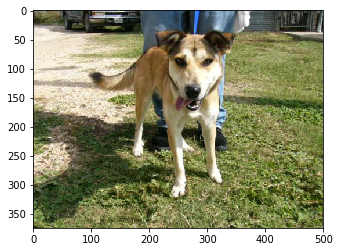

In [14]:
probs, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
result = []
for ind in indices[0][:5]:
    result.append((classes[ind],percentage[ind].item()))
    
plt.imshow(img)
print(result)